In [3]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [4]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)

In [5]:
def CRRA(cons,γ):
    if γ != 1.0:
        return cons**(1.0 - γ) / (1.0 - γ)
    else:
        return np.log(cons)

In [6]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
# !pip install japanize_matplotlib
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
import time # 計測時間をはかるためのパッケージ

# 操作変数を連続変数にする：最適化

- 状態変数と操作変数をともに離散化するアプローチは、離散化するグリッドの数を節約すると精度が非常に悪くなる


- 本来の解である(4)式は線形であるはずなのに、$J=40$のときの貯蓄関数は直線ではない


- そこで、もう少し洗練されたアプローチを考える：状態変数は離散化するが、操作変数については連続的な値をとる

- 経済主体の最適化問題は、各$w_{i}$ for $i=1,\dots,I$について、

$$
  \max_{a} \frac{[w_{i}-a]^{1-\gamma}}{1-\gamma}+\beta\frac{[(1+r)-a]^{1-\gamma}}{1-\gamma} \tag{6}
$$

となるが、操作変数$a\in\mathbb{R}$については任意の実数をとりうる

In [1]:
def obj_two_period(a,w_val,params):
    """
    所得wを所与として、2期間モデルの生涯効用を返す関数
    @author Tokuma Suzuki(Julia ver)
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

    # アウトプット 
    生涯効用:
    """
    # 1期目の効用
    if w_val - a > 0.0:
        util_y = CRRA(w_val - a, params.γ)
    else:
        util_y = -1000000.0 #負の消費に対するペナルティ
    
    # 2期目の割引効用
    util_o = params.β*CRRA((1.0 + params.rent)*a, params.γ)

    # optimizeが最小値を探すので、マイナスをかけることで最適な値を求める。
    return  -1.0*(util_y + util_o)

- どうやって(6)式の解を得ればよいのであろうか？


- とりあえず、最適化(optimization)と呼ばれるライブラリを使う
    - MATLABであれば、Optimization Toolboxにある関数fminsearchやfminbnd
    - Pythonであれば、SciPyにある関数fmin
    - Juliaであれば、Optim.jlにある関数

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(6)式を最大にするような$a$を探し出す。各言語の最適化関数を利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。

In [9]:
# 事前に設定しておいたパラメータをparamsという一つの変数にまとめる：struct
params = Calibration()

# 空の変数を用意
a_gs = np.zeros(params.nw)
from scipy.optimize import Bounds

# 各wについて目的関数を最大にするような貯蓄水準aを求める
for (w_ind,w_val) in enumerate(params.grid_w):
    
    # 関数obj_two_periodを再定義
    # "aのみをargument"とする関数を作る：optimizeの中に入れる関数はパラメータを与えたもとでの関数である必要あり
    obj_two_period1 = lambda a: obj_two_period(a,w_val,params)

    # ブレント法(Brents' method)により計算
    # 使い方：aの最適値を探す範囲を指定→[w_val*0.01, w_val*2.0]
    # この範囲内で関数を最小(最大)にするaを見つけ出すアルゴリズム
    
    res = optimize.fminbound(obj_two_period1,w_val*0.01,w_val*2.0)
    a_gs[w_ind] = res

- 図は、Pythonの最適化関数scipy.optimize.fminboundを使って、各$w_{i}$における最適な$a$を探してプロットした貯蓄関数。操作変数が取りうる値を連続にすることで、計算精度が大幅に改善された。

In [10]:
# 解析解：(2.4)式
coef1 = (params.β*(1.0 + params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0 + params.rent))
a_cfs = coef2*params.grid_w

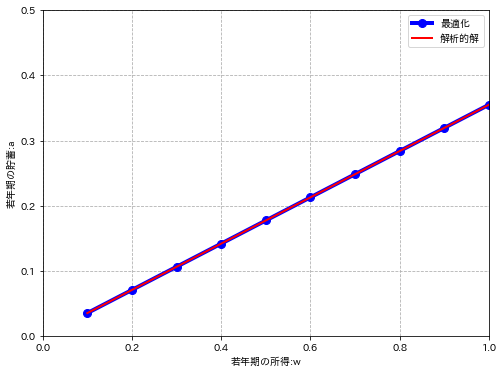

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_gs,c="b",marker="o",lw=4,ms=8,label="最適化")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()